Epoch [50/300] - Loss: 0.0848
Epoch [100/300] - Loss: 0.0451
Epoch [150/300] - Loss: 0.0309
Epoch [200/300] - Loss: 0.0236
Epoch [250/300] - Loss: 0.0191
Epoch [300/300] - Loss: 0.0160


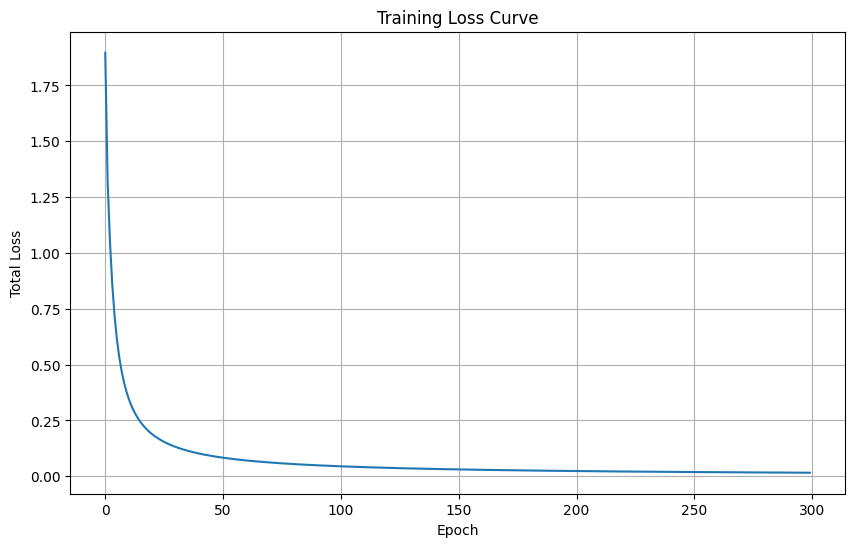


=== Testing ===
Sentence: ['The', 'movie', 'is', 'bad'] ➔ Prediction: 0 (bad)
Sentence: ['The', 'movie', 'is', 'good'] ➔ Prediction: 1 (good)


In [1]:
import torch
import matplotlib.pyplot as plt

# 1. Vocabulary
vocab = {"The": 0, "movie": 1, "is": 2, "good": 3, "bad": 4}

def word_to_onehot(word):
    vec = torch.zeros(len(vocab), 1)
    vec[vocab[word]] = 1.0
    return vec

# 2. Training Samples
train_data = [
    (["The", "movie", "is", "good"], 1),
    (["The", "movie", "is", "bad"], 0)
]

# 3. Define RNN Parameters
n = 2  # hidden size
m = len(vocab)  # vocabulary size
T = 4  # number of words
torch.manual_seed(42)

# Initialize Weights (n x n), (n x m), (n x 1), (2 x n), (2 x 1)
# W: recurrent weight matrix
# U: input weight matrix
# b: bias for hidden state
# W_out: output weight matrix
# b_out: output bias
W = torch.randn(n, n, requires_grad=True)
U = torch.randn(n, m, requires_grad=True)
b = torch.randn(n, 1, requires_grad=True)
W_out = torch.randn(2, n, requires_grad=True)
b_out = torch.randn(2, 1, requires_grad=True)

# 4. Training Setup
learning_rate = 0.1
num_epochs = 300
loss_fn = torch.nn.CrossEntropyLoss()
loss_history = []

# 5. Training Loop
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for sentence, label in train_data:
        inputs = [word_to_onehot(word) for word in sentence]
        s_prev = torch.zeros(n, 1)
        
        for x_t in inputs:
            # Compute s_t using the RNN equation: s_t = tanh(W*s_{t-1} + U*x_t + b)
            s_t = torch.tanh(W @ s_prev + U @ x_t + b)
            s_prev = s_t
        
        # Output layer: logits = W_out * s_T + b_out
        logits = W_out @ s_t + b_out
        logits = logits.view(1, -1)
        
        # Loss
        target = torch.tensor([label])
        loss = loss_fn(logits, target)
        total_loss += loss.item()
        
        # Backward
        loss.backward()
        
        # Manual update (SGD)
        with torch.no_grad():
            W -= learning_rate * W.grad
            U -= learning_rate * U.grad
            b -= learning_rate * b.grad
            W_out -= learning_rate * W_out.grad
            b_out -= learning_rate * b_out.grad
        
        # Zero gradients after updating
        W.grad.zero_()
        U.grad.zero_()
        b.grad.zero_()
        W_out.grad.zero_()
        b_out.grad.zero_()
    
    loss_history.append(total_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f}")

# 6. Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 7. Test After Training
print("\n=== Testing ===")
test_sentences = [
    ["The", "movie", "is", "bad"],
    ["The", "movie", "is", "good"]
]

for test_sentence in test_sentences:
    inputs = [word_to_onehot(word) for word in test_sentence]
    s_prev = torch.zeros(n, 1)
    
    for x_t in inputs:
        # Forward pass again (same as above)
        s_t = torch.tanh(W @ s_prev + U @ x_t + b)
        s_prev = s_t
    
    logits = W_out @ s_t + b_out
    prediction = torch.argmax(logits)
    label_name = "good" if prediction.item() == 1 else "bad"
    print(f"Sentence: {test_sentence} ➔ Prediction: {prediction.item()} ({label_name})")
